## Phase 2 - Solving the Poisson Equation over a Mesh using Finite Elements Methods

#### Zac Keskin - Techniques of High Performance Computing

____

In this problem, we continue the analysis in order to solve an equation over the mesh read in from VTK in Phase 1. We consider the problem

$$ \nabla^2 u=-f $$
 
on a given domain  $Ω$  with boundary conditions $ \Gamma = 0 $


By multiplying by a trial function, $v$, and integrating over the domain, we get the equation:

$$  \iint_\Omega v\, (\nabla \cdot \nabla u )\, \operatorname{dx} \operatorname{dy}
=
 - \iint_\Omega v\, f \operatorname{dx} \operatorname{dy}$$
 
By exploiting the Gauss-Green formula, this can be reformulated into three integral terms:

$$ - \iint_\Omega (\nabla v) \cdot \, \nabla u \, \operatorname{dx} \operatorname{dy} \ +\;
\oint_{\Gamma} v \; \nabla u \cdot \hat{\underline{n}} \, \operatorname {d \underline{S} } \,  \; +\, 
\iint_\Omega v \, f\operatorname{dx}\operatorname{dy} \,=  \,0 $$

By interpolating using the Galerkin approximation: $v = \Psi_i$, and  $U = \sum \Psi_j U_j $ -  we recover expressions corresponding to the Stiffness matrix, Boundary vector and Force vector for a given element. Since we have (by the boundary conditions) that the boundary vector is zero, we are left with: 

$$ \sum_{j}^{N}\;  \iint_\Omega (\nabla \Psi_i)\cdot \nabla \Psi_j \; u_j \, \operatorname{dx} \operatorname{dy} \, =\,
0 + 
\iint_\Omega N_i\, \operatorname{dx} \operatorname{dy}$$

For each node $i$, which can be considered a system of equations to be represented in matrix form as:

$$ Ku = F_l $$ 

For ease of calculation, we can instead interpolate over the reference element, and then transform to the coordinates of the mesh element, using the Jacobian as follows, to give a calculation of the local (3x3) stiffness matrix for each element:


$$K_{ij} = \iint_\Omega \; J^{-T} \nabla \Psi_i \;  \cdot  \;  J^{-T} \nabla \Psi_j  \;\;\operatorname{det}(J)\;\, dxdy $$ 

where $J^{-T}$ is the 3x3 matrix of the inverse Jacobian transpose.
and nodal shape functions over the triangle reference element are given by :    $$\Psi_0 = 1 - x -y $$
          $$\Psi_1 = y $$
          $$\Psi_2 = x $$

We find for each $K_{ij}$ that the integrand is given solely in terms of elements of the inverse Jacobian transpose matrix (i.e. $J^{-1}_{ij}$ ), and so we can take this outside of the integral for each $K_{ij}$, leaving simply the area of the reference element, which is $\frac12$. For example: 

$$ K_{22} = \frac12 \left( (J_{00}^{-T})^2 + (J_{11}^{-T})^2 + (J_{22}^{-T})^2 \cdot \operatorname{det}(J)\right)$$

In this way, we can consider the calculation of each term of the local stiffness matrix as a simple arithmetic problem, which could be easily implemented in parallel. Once complete, the local-to-global mapping information stored in the VTK file would allow for assembly of the global stiffness matrix $K_G$.

However, we can further improve on the efficiency of the design, by careful consideration of the end-to-end process for solving for $\underline{x}$ Specifically, we recognise that we are only interested in the result of the matrix-vector product $K_G \,\underline{x}$.


e.g. $$\underline{v}_0 =  K_{00} x_0 + K_{01} x_1 +  ... + K_{0N} x_N $$

We therefore do not need to assemble $K_G$ in memory; nor do we need to then multiply this matrix by the $\underline{x}$ vector. We can instead wrap the matrix-vector product in a Scipy LinearOperator class, such that the scalar result of the $K \underline{x}$ product is returned for any given $\underline{x}$: 

In this way we formulate the entire process in terms of an arithmetic problem, by carefully multiplying $K_ij$ terms with $J^{-T}_{ij}$ terms as appropriate, which can then be parallelised using OpenCL. This end-to-end process is now presented below.

In [1]:
##########################################################################
#####    Grid class from Phase 1 imported from .py file in local directory 
##########################################################################
from phase1 import Grid

In [2]:
import os, time
import numpy as np
import pyopencl as cl
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator

from scipy.sparse.linalg import isolve
os.environ['PYOPENCL_CTX']='0:1'
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

dtype_string = 'float32'     # Choose float32 or float64
device = 'CPU' 

In [3]:
##########################################################################
#####    Create new OpenCL Context
##########################################################################

platforms = cl.get_platforms()
if device == 'GPU' and len(platforms[0].get_devices(device_type=cl.device_type.GPU)) > 0:
    devices = platforms[0].get_devices(device_type=cl.device_type.GPU)
else:
    devices = platforms[0].get_devices(device_type=cl.device_type.CPU)


# Check that the device can handle double precision
if devices[0].double_fp_config == 0 and dtype_string == 'float64':
    print('Your selected device can not use double precision decimals. \n ' +
            'Running simulation using single precision floats \n')
    dtype_string = 'float32'


# Configure type for np arrays
if dtype_string == 'float64':
    dtype = np.float64
else:
    dtype_string = 'float32'
    dtype = np.float32


context = cl.Context(devices=devices)
queue = cl.CommandQueue(context) 
mem_flags = cl.mem_flags

print('Operating on ' + str(devices[0].max_compute_units) + ' threads', '\n' )
print('With datatype np.' + dtype_string)

Operating on 4 threads 

With datatype np.float32


In [4]:
##########################################################################
#####    Import Data from VTK (Using Phase 1) and store in np arrays
##########################################################################

grid = Grid.from_file('lshape.vtk', dtype='float32')
n_elements = len(grid.elements)
# Get 3x3 J^-T for each element of mesh
Js = [np.zeros((3,3)) for e in range(n_elements)]
for i in range(n_elements):
    Js[i][:,:-1] = grid.inverse_jacobian_transpose(i)
Js = np.array(Js).flatten()
detJs = np.array([grid.integration_element(i) for i in range(n_elements)])

The Ax_operator function wraps a Python-only implementation of the process outlined above, to perform the $Kx$ matrix - vector product.  This is then compared later with the OpenCL implementation.

In [5]:
##########################################################################
#####    Perform  Matrix - Vector Product
##########################################################################

def Ax_operator(x_vec):
    # Return result of matrix-vector multiplication between Global stiffness matrix and provided vector
    N = len(grid.vertices)
    x_vec.reshape(N,1)
    K = np.zeros(shape=(N,N))

    Ax_vec = np.zeros_like(x_vec)
    
    for element_index, e in enumerate(grid.elements):
        # Get 3x3 Jacobian
        J = grid.inverse_jacobian_transpose(element_index)
        b = np.zeros((3,3))
        b[:,:-1] = J
        J = b
        detJ = grid.integration_element(element_index)
        
        

        # K_11
        Ax_vec[e[0]] +=  x_vec[e[0]]  *     (J[0][0]**2   +   2 * (J[0][0]*J[0][1])   +   J[0][1]**2     +
                                            J[1][0]**2   +   2 * (J[1][0]*J[1][1])   +   J[1][1]**2     +
                                            J[2][0]**2   +   2 * (J[2][0]*J[2][1])   +   J[2][1]**2     )*detJ
        # K_12
        Ax_vec[e[0]] +=  x_vec[e[1]]  *     (-(J[0][0]**2 + J[0][1] * J[0][0])   +   
                                            -(J[1][0]**2 + J[1][1] * J[1][0])   +   
                                            -(J[2][0]**2 + J[2][1] * J[2][0])   )*detJ   
                                            
        # K_13
        Ax_vec[e[0]] +=  x_vec[e[2]]  *     (-(J[0][0] * J[0][1] + J[0][1]**2)   +
                                            -(J[1][0] * J[1][1] + J[1][1]**2)   +
                                            -(J[2][0] * J[2][1] + J[2][1]**2)   )*detJ
        
        # K_21 (from symmetry)
        Ax_vec[e[1]] +=  x_vec[e[0]]  *     (-(J[0][0]**2 + J[0][1] * J[0][0])   +   
                                            -(J[1][0]**2 + J[1][1] * J[1][0])   +   
                                            -(J[2][0]**2 + J[2][1] * J[2][0])   )*detJ 
        # K_22
        Ax_vec[e[1]] +=  x_vec[e[1]] * (J[0][0]**2  +   J[1][0]**2   +    J[2][0]**2)*detJ
        

        # K_23
        Ax_vec[e[1]] +=  x_vec[e[2]] *      (J[0][1]*J[0][0]  +  J[1][1]*J[1][0]  +  J[2][1]*J[2][0])*detJ

        # K_31 (from symmetry)
        Ax_vec[e[2]] +=  x_vec[e[0]]  *     (-(J[0][0] * J[0][1] + J[0][1]**2)   +
                                            -(J[1][0] * J[1][1] + J[1][1]**2)   +
                                            -(J[2][0] * J[2][1] + J[2][1]**2)   )*detJ
        
        # K_32  (from symmetry)
        Ax_vec[e[2]] +=  x_vec[e[1]]  *     (J[0][1]*J[0][0]  +  J[1][1]*J[1][0]  +  J[2][1]*J[2][0])*detJ

        # K_33
        Ax_vec[e[2]] +=  x_vec[e[2]]  *     (J[0][1]**2  +  J[1][1]**2  +  J[2][1]**2)*detJ
        
        
    Ax_vec[:128] = 0 
    
    return 0.5* Ax_vec

We now define a second function to perform the matrix-vector product; this time using OpenCL. The key difference is there is no longer a need for a loop - the problem is embarrassingly parallel, and each thread can perform one step of the loop independent of the others.

The one major complexity is that we are also assembling the global matrix $K_G$ during the process, and so multiple threads must contribute additions to the shared memory locations, due to 3072 threads assembling contributions to 1601 vertices. 

This reduction operation is not directly possible in OpenCl, as addition-assignment operations (+=) are not thread-safe. Instead, each thread is allocated a local vector into which the element addition-assignments are stored. Each thread then writes its own row-vector to a global 3072*1601 matrix, which is efficiently summed columnwise using numpy vector operations.

The other key challenge is including boundary conditions. We know the shape of the domain and can hard-code conditional checks to a function, which returns 0 where the nodes are on the boundary. However, it can be seen that this is equivalent and computationally more taxing than manually setting the values to zero where these are known, so we have ensured the boundary nodes are set to 0. 

In [6]:
def opencl_Ax_operator(x_vec):

    n_nodes = len(grid.vertices)
    n_elements = len(grid.elements)
    
    output = np.zeros((n_elements,len(x_vec))).astype(dtype)
    Ax = np.zeros_like(x_vec).astype(dtype)
    
    ## Create OpenCL Buffers

    J_buffer = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf= Js.astype(dtype))
    det_buffer = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf= detJs.astype(dtype))
    node_buffer = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf= grid.elements.astype(np.int32))

    vector_buffer = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf= x_vec.astype(dtype))
    output_buffer = cl.Buffer(context, mem_flags.WRITE_ONLY, output.nbytes)

    kernel = """
                __kernel void Ax(
                                const int N,
                                const __global float *J,
                                const __global float *dets,
                                const __global int *nodes,
                                const __global float *x_vector,
                                    __global float *output){
                        
                        // Thread identifiers
                        const int GID = get_global_id(0);
                        float local_vector[1601]={0}; //Note that Apple OpenCL doesn't allow variable-length arrays
                        float detJ = dets[GID];
                        

                        // Because of multiple contributions, from different elements, to the same node value, different threads
                            // need to be added to the same Ax[i] term, which can not be done in parallel. Instead these are added to local_vector[i]
                            // and each local vector is returned as one row in a 2D array to Numpy, which can be summed column-wise to perform the reduction.

                         // K_11
                        local_vector[nodes[GID*3+0]] +=  x_vector[nodes[GID*3+0]]  * (J[GID*9+0]*J[GID*9+0]   +   2 * J[GID*9+0]*J[GID*9+1]   +   J[GID*9+1]*J[GID*9+1]  +
                                                                          J[GID*9+3]*J[GID*9+3]   +   2 * J[GID*9+3]*J[GID*9+4]   +   J[GID*9+4]*J[GID*9+4]  +
                                                                          J[GID*9+6]*J[GID*9+6]   +   2 * J[GID*9+6]*J[GID*9+7]   +   J[GID*9+7]*J[GID*9+7]   )
                                                                *   detJ 
                        
                            // K_12
                                        +  x_vector[nodes[GID*3+1]]  *   (-(J[GID*9+0]*J[GID*9+0]  +  J[GID*9+1]*J[GID*9+0])  +  
                                                                        -(J[GID*9+3]*J[GID*9+3]  +  J[GID*9+4]*J[GID*9+3])  +   
                                                                        -(J[GID*9+6]*J[GID*9+6]  +  J[GID*9+7]*J[GID*9+6])  )
                                                                *  detJ

                        
                            // K_13
                                        +  x_vector[nodes[GID*3+2]]  *    (-(J[GID*9+0]*J[GID*9+1] + J[GID*9+1]*J[GID*9+1]) +
                                                                         -(J[GID*9+3]*J[GID*9+4] + J[GID*9+4]*J[GID*9+4]) +
                                                                         -(J[GID*9+6]*J[GID*9+7] + J[GID*9+7]*J[GID*9+7]) )
                                                                *  detJ;

                        
                            // K_21 (from symmetry = K_12)
                        local_vector[nodes[GID*3+1]] +=  x_vector[nodes[GID*3+0]]  * (-(J[GID*9+0]*J[GID*9+0]  +  J[GID*9+1]*J[GID*9+0])  +  
                                                                          -(J[GID*9+3]*J[GID*9+3]  +  J[GID*9+4]*J[GID*9+3])  +   
                                                                          -(J[GID*9+6]*J[GID*9+6]  +  J[GID*9+7]*J[GID*9+6])  )
                                                                *  detJ

                            // K_22
                                            +  x_vector[nodes[GID*3+1]] * (J[GID*9+0]*J[GID*9+0] + 
                                                                         J[GID*9+3]*J[GID*9+3] +
                                                                         J[GID*9+6]*J[GID*9+6] ) 
                                                                *  detJ


                            // K_23
                                            +  x_vector[nodes[GID*3+2]] * (J[GID*9+1]*J[GID*9+0]  +
                                                                         J[GID*9+4]*J[GID*9+3]  +  
                                                                         J[GID*9+7]*J[GID*9+6]  )
                                                                *  detJ;

                        
                            // K_31 (from symmetry = K_13)
                            
                        local_vector[nodes[GID*3+2]] +=  x_vector[nodes[GID*3+0]] * (-(J[GID*9+0]*J[GID*9+1] + J[GID*9+1]*J[GID*9+1]) +
                                                                         -(J[GID*9+3]*J[GID*9+4] + J[GID*9+4]*J[GID*9+4]) +
                                                                         -(J[GID*9+6]*J[GID*9+7] + J[GID*9+7]*J[GID*9+7]) )
                                                                *  detJ    

                            // K_32  (from symmetry = K_23)
                                            +  x_vector[nodes[GID*3+1]] * (J[GID*9+1]*J[GID*9+0]  +
                                                                         J[GID*9+4]*J[GID*9+3]  +  
                                                                         J[GID*9+7]*J[GID*9+6]  )
                                                                *  detJ
                        
                            // K_33
                                            +  x_vector[nodes[GID*3+2]]  *  (J[GID*9+1]*J[GID*9+1]  +
                                                                           J[GID*9+4]*J[GID*9+4]  + 
                                                                           J[GID*9+7]*J[GID*9+7])
                                                                    *  detJ;

                            
                            // Each thread saves its contribution to part of the output array                                                                    
                            for (int i = 0; i<1601; i++)
                                {
                                output[1601*GID+i] = local_vector[i];
                                } 
               
                    }
                """
    if dtype_string == 'float64':
            kernel = kernel.replace("global float ", "global double ")
            
    ## Run Program
    program = cl.Program(context, kernel).build()
    program.Ax(queue, (n_elements,), None, np.int32(n_elements), J_buffer, det_buffer, node_buffer, vector_buffer, output_buffer)
    
    # Return data from device and return
    cl.enqueue_copy(queue, output, output_buffer)


    # So now we should have 3072 rows of 1601 vectors.. So np.reduce sum (columnwise) to get Ax
    Ax = np.sum(output, axis=0)

    Ax[:128]=0
    return 0.5*Ax

### Force/Load Vector
The physical behaviour of the system is interesting only in the non-trivial case of non-zero forcing terms. In this case we have the heat equation, a diffusive partial differential equation, and so the force vector can be considered a source of heat. The equation therefore models the way the heat is transfered throughout the body, which is interpolated across the nodes of the mesh.

To do this we must calculate this force vector. From the above derivation using Finite Element Analysis, we find the terms of the local (3x1) force vector is given by:

$$ \underline{F_l} (i) = \iint_\Omega\ \; f(i) \,\psi_i \,\operatorname{dx} \operatorname{dy} $$

where $ f(i) $ is the value of the function at node $i$.

In the example case, where $ f(i) = 1 \forall i $, we can evaluate this explicitly over the reference element and then transform using the inverse jacobian transpose. For example, 

$$ \underline{F_l} (0) \;=\; \operatorname{det}(J) \, \int^1_{x=0}\int^{1-x}_{y=0} \; (1-x-y) \,\operatorname{dx} \operatorname{dy} \;=\; \frac16 \operatorname{det}(J)$$ 

In the more general case, this can be approximated using numerical integration to interpolate over the reference element and transform, as before. This gives 
$$ \underline{F_l} (i) \;=\; \frac{\operatorname{det}(J)}{24} \left(f(i) + \sum_{j=1}^3 {f(j)}  \right)$$

where, like above, $f(j)$ is the value of the function at node $j$. This method has been implemented below using OpenCL, to allow the efficient calculation and assembly of local force vectors into the global force vector.

In [31]:
##########################################################################
#####    Define Functions acting on RHS
##########################################################################

def uniform_0(node):
    return 0

def uniform_1(node):
    return 1

def sin(node): 
    # Magnitude of position vector, scaled to show sinusoidal behavior over unit square
    return np.sin(4*np.pi*np.linalg.norm(node))

def squared(node): 
    return node*node

In [32]:
##########################################################################
#####    Calculate RHS (Force Vector)
##########################################################################

def global_force_vector(): # Python-only implementation for case f = 1
    b = np.zeros((len(grid.vertices),))
    
    for element_index, e in enumerate(grid.elements):
        detJ = grid.integration_element(element_index)
        b[e[0]] += (1/6)*detJ
        b[e[1]] += (1/6)*detJ
        b[e[2]] += (1/6)*detJ
        b[0:128]=0
    return b


In [33]:
def opencl_global_force_vector(func):

    n_nodes = len(grid.vertices)
    n_elements = len(grid.elements)
    f_vector = np.array([func(node) for node in grid.vertices])
    output = np.zeros((n_elements,n_nodes)).astype(dtype)
    
    ## Create OpenCL Buffers
    det_buffer = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf= detJs.astype(dtype))
    node_buffer = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf= grid.elements.astype(np.int32))

    force_buffer = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf= f_vector.astype(dtype))
    output_buffer = cl.Buffer(context, mem_flags.WRITE_ONLY, output.nbytes)
    
    
    # Send function evaluated at each point to OpenCL to interpolate
    kernel = """__kernel void RHS(
                                const int N,
                                const __global float *dets,
                                const __global int *nodes,
                                const __global float *F,
                                      __global float *output){
                                    
                        // Thread identifiers
                        const int GID = get_global_id(0);
                        float local_vector[1601]={0}; //Note that Apple OpenCL doesn't allow variable-length arrays
                        float detJ = dets[GID];
                        
                        // Interpolate over each element
                        local_vector[nodes[GID*3]] = detJ/24 * (2*F[nodes[GID*3]] + F[nodes[GID*3+1]] + F[nodes[GID*3+2]]);
                        
                        // Each thread saves its contribution to part of the output array                                                                    
                        for (int i = 0; i<1601; i++)
                            {
                            output[1601*GID+i] = local_vector[i];
                            }             
                        
            }"""
    
    if dtype_string == 'float64':
        kernel = kernel.replace("global float ", "global double ")
            
    ## Run Program
    program = cl.Program(context, kernel).build()
    program.RHS(queue, (n_elements,), None, np.int32(n_elements), det_buffer, node_buffer, force_buffer, output_buffer)
    
    # Return data from device and return
    cl.enqueue_copy(queue, output, output_buffer)

    # So now we should have 3072 rows of 1601 vectors.. So np.reduce sum (columnwise) to get Ax
    b = np.sum(output, axis=0)
    
    b[0:128]=0

    return b

In [34]:
#b = opencl_global_force_vector(uniform_1)
b = opencl_global_force_vector(sin)

### Solving Linear System of Equationa Ax=b
We have now assembled a global system of simultaneous equation describing the heat at each node of the mesh resulting from the force vector. We can make use of common iterative solvers to return a solution of the equation, which can then be plotted

In [39]:
##########################################################################
#####      Solve Ax = b 
##########################################################################

# Wrap Functions in SciPy LinearOperators
A1 = LinearOperator(  ( len(b),len(b) ), matvec =  Ax_operator)
A2 = LinearOperator(  ( len(b),len(b) ), matvec =  opencl_Ax_operator)
    
class solver():
    def __init__(self,Ax_operator,vec):
        self.i = 0
        self.b = vec
        self.A = Ax_operator
        self.x = np.zeros_like(self.b)

    def callback(self, x):
        self.i += 1
        #print(self.i)
        self.r = self.A(x) - self.b
        #self.r = np.matmul(self.A,x) - self.b
        #print("Error:  " + str(np.linalg.norm(self.r)))

    def cg(self):
        self.x, self.success = scipy.sparse.linalg.cg(self.A, self.b, x0=self.x, callback=self.callback, tol=1e-3, maxiter=200, M=None)
    def bicgstab(self):
        self.x, self.success = scipy.sparse.linalg.bicgstab(self.A, self.b, x0=self.x, callback=self.callback, tol=1e-3, maxiter=100, M=None)

### Timing Implementations
Having implemented efficient Matrix-Vector product functions in both pure Python and OpenCL, it behooves us to perform a comparison of the calculation time for each method.

In [40]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [41]:
py_solver = solver(A1,b)
opencl_solver = solver(A2,b)

with Timer() as t:
    py_solver.cg() 
print("Python-only Implementation:", t.interval)
print("Number of Iterations:", py_solver.i,'\n')

with Timer() as t:
    opencl_solver.cg() 

print("OpenCL Implementation:", t.interval)
print("Number of Iterations:", opencl_solver.i)
x = opencl_solver.x

Python-only Implementation: 19.70085883140564
Number of Iterations: 59 

OpenCL Implementation: 5.115687131881714
Number of Iterations: 59


We see significant improvement in the performance, roughly a four-fold increase when parallelised over 4 CPU cores! This is a testament to the efficient design, where we have been able to implement a matrix-free variant with zero loops required in OpenCL.

### Plotting the Solution
We have a result for the nodal $u$ values over the whole mesh. Matplotlib allows us to plot this as a triangulated surface plot over the L-shape domain, (conveniently in the form of our chosen P1 three-node triangular elements).

Using %matplotlib notebook cell magic in Jupyter, the user can rotate and zoom the plot in-browser.

<IPython.core.display.Javascript object>


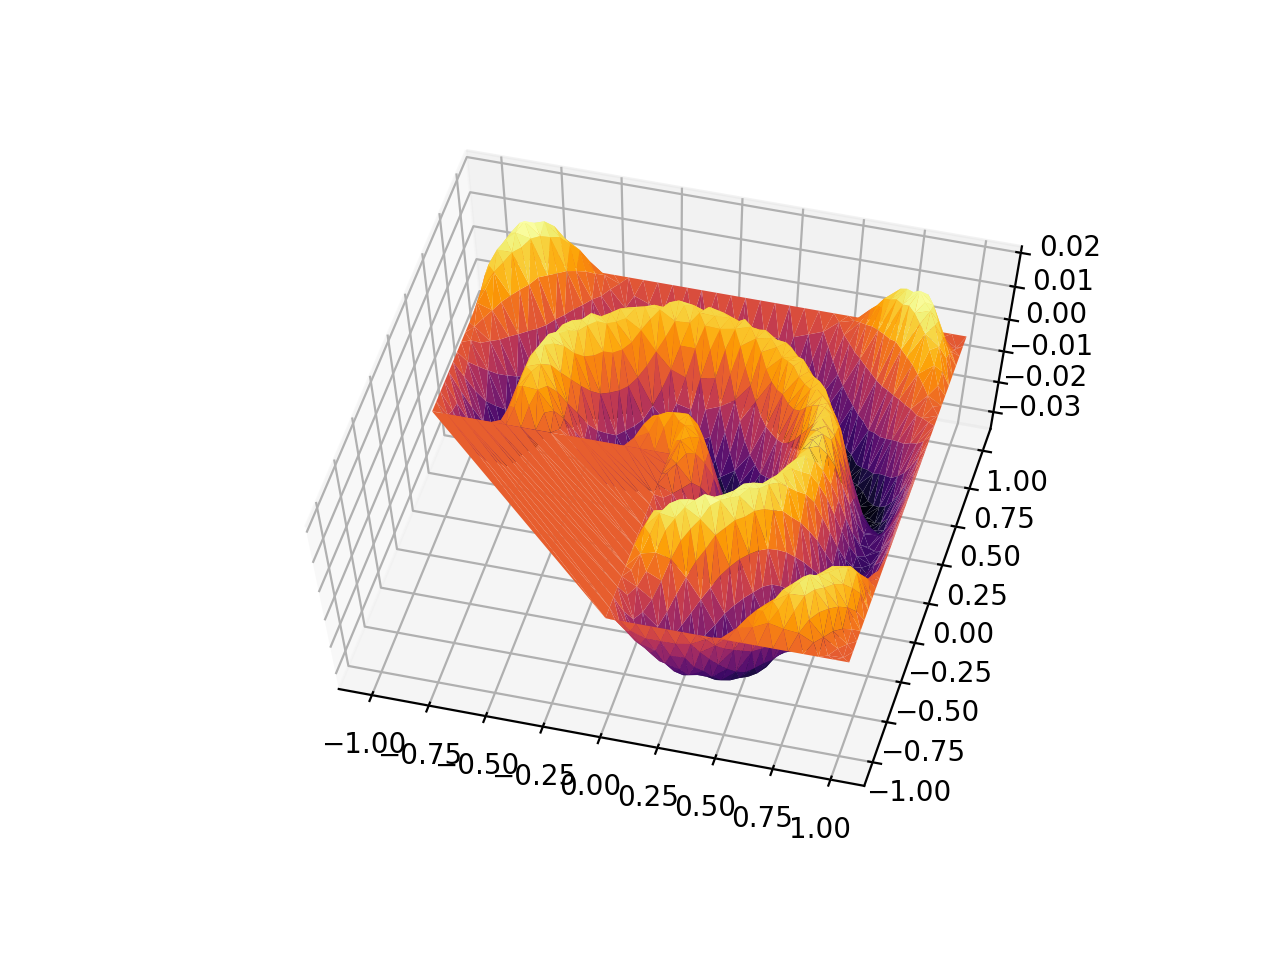

In [42]:
##########################################################################
#####      Plot Mesh
##########################################################################
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

x.resize((1601,))
ax.plot_trisurf(grid.vertices[:,0], grid.vertices[:,1], x, cmap='inferno')

plt.show()